Importing necesssary files

In [79]:
!pip install nsepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nsepy
from datetime import date

Getting data

In [0]:
infy_df = nsepy.get_history(symbol='INFY',
                    start=date(2015,1,1), 
                    end=date(2015,12,31))

In [81]:
infy_df.index = pd.to_datetime(infy_df.index)
print(type(infy_df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Feature Extraction

In [0]:
import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower()).astype(np.int64)
    if drop: df.drop(fldname, axis=1, inplace=True)

Data preprocessing and scaling

In [83]:
infy_df['Date'] = infy_df.index
add_datepart(infy_df, 'Date')

X = infy_df.drop(['Close','Symbol','Series'],axis = 1)
y = infy_df['Close']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Train and Test Split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Linear Regression (Tuned)

In [0]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
#make predictions and find the rmse
preds = model.predict(X_test)

In [87]:
print(mean_absolute_percentage_error(y_test, preds))

0.13281184206483762


### Lasso Regression

In [88]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=0.01)
reg.fit(X_train,y_train)
#make predictions and find the rmse
preds_lasso = reg.predict(X_test)
print(mean_absolute_percentage_error(y_test, preds_lasso))

0.14827695429380905


### Quick build SVM

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
svc = svm.SVR(gamma="scale")
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001,0.01,0.1,1,10],'epsilon':[0.01,0.1]}
clf = GridSearchCV(svc, parameters, cv=3)
clf.fit(X_train,y_train)
#make predictions and find the rmse
preds_clf = clf.predict(X_test)
print(mean_absolute_percentage_error(y_test, preds_clf), clf.best_params_)

0.5496229595695824 {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}


#### Prove your model does not violate any basic assumption: for Linear Regression

In [0]:
import statsmodels
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Linearity & Equal variance
Both can be tested by plotting residuals vs. predictions, where residuals are prediction errors

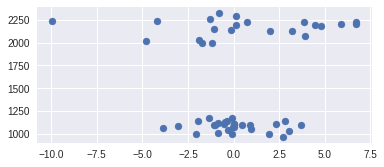

In [91]:
residual = y_test - preds
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual, preds)

#### Normality
We can apply normal probability plot to assess how the data (error) depart from normality visually

0.9361996090695328

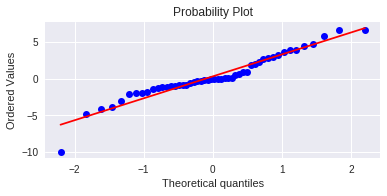

In [92]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

The good fit indicates that normality is a reasonable approximation.


### Select best performing model, and tune it - Demonstrate that your tuning has resulted in a clear difference between quick build and tuning.

Ans: There is a considerable deifference in MAPE of Quick Buid SVM and Tuned Linear Regression